<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Деление-выборки-на-части" data-toc-modified-id="Деление-выборки-на-части-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Деление выборки на части</a></span></li><li><span><a href="#Обучение-модели-ResNet-50" data-toc-modified-id="Обучение-модели-ResNet-50-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели ResNet 50</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Обработка фотографий покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Импортируем ResNet из Keras. 50 означает количество слоёв в сети.
from tensorflow.keras.applications.resnet import ResNet50

# Библиотека для загрузки файлов с Google-диска
from google.colab import drive

Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/).

In [2]:
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/datasets/14_customer_photos/"

# csv-файл labels.csv с двумя колонками: file_name и real_age
labels = pd.read_csv(path + 'labels.csv')

Mounted at /content/gdrive


In [3]:
# Указываем параметры загрузчика
datagen = ImageDataGenerator(
    # поделим значения яркости на 255
    rescale=1/255,
    # поворачиваем изображения на случайный угол
    rotation_range=0,
    # отражение по горизонтали и вертикали
    horizontal_flip=False,
    vertical_flip=False,
    # cдвиги изображения по горизонтали и вертикали
    width_shift_range=0,
    height_shift_range=0)

# создаём обучающую выборку
datagen_flow = datagen.flow_from_dataframe(
    # Датафрейм, содержащий пути к файлам изображений в строковом столбце
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    # Аргумент с шириной и высотой, к которым будут приводиться изображения.
    # ResNet50 обучался на изображениях 224*224, поэтому и здесь нужно использовать такой размер
    target_size=(224, 224),
    # Количество изображений в батче. 
    # На каждом шаге градиентного спуска градиенты считаются только по объектам из текущего батча.
    batch_size=16,
    # Eсли class_mode="raw", датафрейм должен содержать выходные данные, указанные в y_col.
    class_mode='raw',
    # Фиксируем генератор случайных чисел
    seed=12345)

Found 7591 validated image filenames.


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


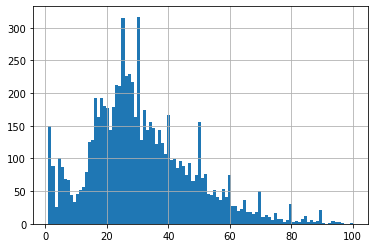

In [5]:
plt.hist(labels['real_age'], bins=100)
plt.grid()
plt.show()

Выводы:

1. На гистограмме наблюдаются выбросы, соответствующие круглым датам: 25, 30, 40, 50, ..., 90 лет. Это может быть связано с тем, что человек, размечавший датасет, зачастую определял возраст "на глаз".
2. Наблюдаются выбросы соответствующие возрасту до 10 лет. Не гипотез по этому поводу.

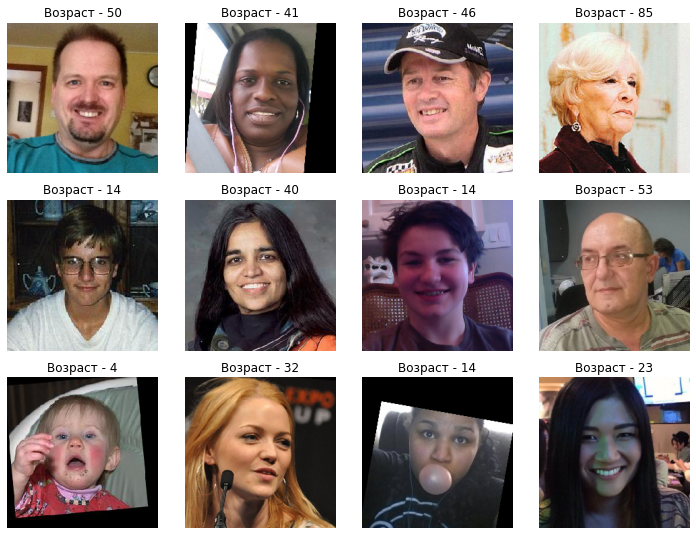

In [6]:
features, target = next(datagen_flow)

# выводим 12 изображений
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст - {target[i]}')
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.axis("off")
    # функция tight_layout изменяет размер подграфика, чтобы включить его в область графика 
    plt.tight_layout()

Вывод. Некоторые фотографии повёрнуты. Чтобы нейросеть лучше обучилась, можно попробовать применить аугментацию: 
1. зеркальное отражение по горизонтали; 
2. случайные повороты на угол до 15 градусов. 

## Деление выборки на части

In [7]:
# Загрузка обучающей выборки
def load_train(path):

    # Указываем параметры загрузчика
    train_datagen = ImageDataGenerator(
    # указываем загрузчику, что валидация содержит 25% случайных объектов
    validation_split=0.25,
    # поделим значения яркости на 255
    rescale=1/255,
    # поворачиваем изображения на случайный угол
    rotation_range=0,
    # отражение по горизонтали и вертикали
    horizontal_flip=False,
    vertical_flip=False,
    # cдвиги изображения по горизонтали и вертикали
    width_shift_range=0,
    height_shift_range=0)

    # создаём обучающую выборку
    train_datagen_flow = train_datagen.flow_from_dataframe(
    # Датафрейм, содержащий пути к файлам изображений в строковом столбце
    dataframe=pd.read_csv(path + 'labels.csv'),
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    # Аргумент с шириной и высотой, к которым будут приводиться изображения.
    # ResNet50 обучался на изображениях 224*224, поэтому и здесь нужно использовать такой размер
    target_size=(224, 224),
    # Количество изображений в батче. 
    # На каждом шаге градиентного спуска градиенты считаются только по объектам из текущего батча.
    batch_size=16,
    # Eсли class_mode="raw", датафрейм должен содержать выходные данные, указанные в y_col.
    class_mode='raw',
    # указываем тип выборки
    subset='training',
    # Фиксируем генератор случайных чисел
    seed=12345)

    return train_datagen_flow

In [8]:
# Загрузка тестовой выборки
def load_test(path):

    # Указываем параметры загрузчика
    test_datagen = ImageDataGenerator(
    # указываем загрузчику, что валидация содержит 25% случайных объектов
    validation_split=0.25,
    # поделим значения яркости на 255
    rescale=1/255)

    # создаём обучающую выборку
    test_datagen_flow = test_datagen.flow_from_dataframe(
    # Датафрейм, содержащий пути к файлам изображений в строковом столбце
    dataframe=pd.read_csv(path + 'labels.csv'),
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    # Аргумент с шириной и высотой, к которым будут приводиться изображения.
    # ResNet50 обучался на изображениях 224*224, поэтому и здесь нужно использовать такой размер
    target_size=(224, 224),
    # Количество изображений в батче. 
    # На каждом шаге градиентного спуска градиенты считаются только по объектам из текущего батча.
    batch_size=16,
    # Eсли class_mode="raw", датафрейм должен содержать выходные данные, указанные в y_col.
    class_mode='raw',
    # указываем тип выборки
    subset='validation',
    # Фиксируем генератор случайных чисел
    seed=12345)

    return test_datagen_flow

## Обучение модели ResNet 50

In [9]:
# Создание модели
def create_model(input_shape):
    
    backbone = ResNet50(
                        # Размер входного изображения. Например: (640, 480, 3).
                        input_shape=input_shape,
                        
                        # Количество нейронов в последнем полносвязном слое, в котором выполняется классификация.
                        # classes=1000,
                        
                        # Инициализация весов. ImageNet — название большого датасета, на котором сеть обучалась классифицировать изображения на 1000 классов. Если обучение сети начать на ImageNet, а продолжить на вашей задаче, результат будет лучше, чем если обучать с нуля. Чтобы инициализация весов была случайной, напишите weights=None.
                        weights='imagenet',
                        # weights=path +'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        
                        # Указание на то, что в конце архитектуры ResNet есть два слоя: GlobalAveragePooling2D и Dense. Если задать False, то этих слоёв не будет.
                        include_top=False
                        )

    # Замораживаем ResNet50 без верхушки.
    # «Заморозим» часть сети: некоторые слои оставим с весами из ImageNet, они не будут обучаться градиентным спуском.
    # backbone.trainable = False

    # инициализируем модель
    model = Sequential()

    # backbone (англ. «костяк») — то, что осталось от ResNet50.
    model.add(backbone)

    # Пулинг с окном во весь тензор. Как и AveragePooling2D, возвращает среднее значение из группы пикселей внутри канала. 
    # GlobalAveragePooling2D нужен, чтобы усреднить информацию по всему изображению, то есть получить пиксель с большим количеством каналов (например, 512 для ResNet50).
    model.add(GlobalAveragePooling2D())
    
    # Полносвязный (выходной) слой
    # Количество нейронов равно количеству возможных значений выходного параметра.
    model.add(Dense(units=1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    # optimizer = 'sqd'

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

In [10]:
# Обучение модели
def train_model(model, 
                train_data, 
                test_data,
                batch_size=None,
                epochs=5,
                steps_per_epoch=None, 
                validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)
    return model

In [12]:
train_data = load_train(path)
test_data = load_test(path)
model = create_model(input_shape = (224, 224, 3))
model = train_model(model, train_data, test_data)

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


356/356 - 4685s - loss: 202.3462 - mae: 10.2855 - val_loss: 525.9788 - val_mae: 17.6401 - 4685s/epoch - 13s/step
Epoch 2/5
356/356 - 4395s - loss: 72.4088 - mae: 6.5154 - val_loss: 118.4405 - val_mae: 8.4686 - 4395s/epoch - 12s/step
Epoch 3/5
356/356 - 4362s - loss: 47.1558 - mae: 5.2934 - val_loss: 75.5043 - val_mae: 6.7243 - 4362s/epoch - 12s/step
Epoch 4/5
356/356 - 4342s - loss: 32.3478 - mae: 4.3585 - val_loss: 152.6185 - val_mae: 10.2327 - 4342s/epoch - 12s/step
Epoch 5/5
356/356 - 4402s - loss: 25.0383 - mae: 3.8594 - val_loss: 103.8956 - val_mae: 7.8228 - 4402s/epoch - 12s/step


In [14]:
# Сохраняем полученные веса модели в файл
model.save(path + 'model_customer_photos.h5')

## Анализ обученной модели

1. В результате обучения модели достигнуто значение MAE = 6.72, которое меньше допускаемого MAE = 8. Цель проекта достигнута.
2. Объём выборки оказался достаточным и не потребовал прибегать в аугментации и "замораживанию" части сети ResNet50.
3. Итогове значение MAE зависит от случайных факторов, а именно, от состава батчей. В ряде случаев минимальное значение MAE достигалось уже на 3-й эпохе при одном и том же значении learning_rate=0,0001.

## Чек-лист

- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  MAE модели не больше 8